In [10]:
import pandas as pd
import numpy as np

# 1. Charger le fichier
file_path = r"C:\Users\ADMIN\Desktop\building1298.csv"
df = pd.read_csv(file_path)

# 2. Convertir datetime
df["datetime"] = pd.to_datetime(df["datetime"])

# 3. Extraire les caractéristiques temporelles
df["hour"] = df["datetime"].dt.hour
df["dayofweek"] = df["datetime"].dt.dayofweek
df["month"] = df["datetime"].dt.month

# 4. Créer la variable dérivée : delta_temp
df["delta_temp"] = df["air_temperature"] - df["dew_temperature"]

# 5. Découpage train/test
df = df.sort_values("datetime").reset_index(drop=True)
train_df = df.iloc[:700]
test_df = df.iloc[700:900]

In [22]:
print("Nombre d'observations :", df["m0"].shape[0])
print("Nombre d'observations train :", train_df["m0"].shape[0])
print("Nombre d'observations test :", test_df["m0"].shape[0])

Nombre d'observations : 8784
Nombre d'observations train : 700
Nombre d'observations test : 200


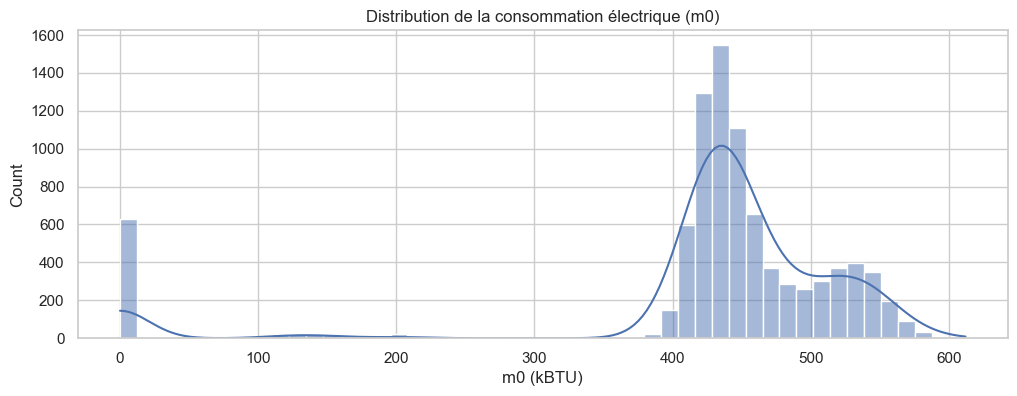

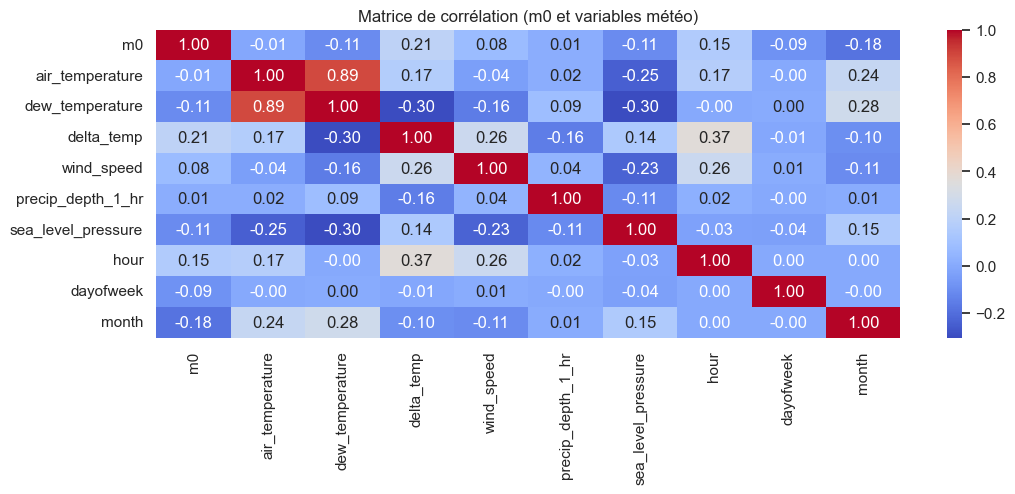

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Style graphique
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 4)

# 1. Distribution de la cible (m0)
plt.figure()
sns.histplot(df["m0"], bins=50, kde=True)
plt.title("Distribution de la consommation électrique (m0)")
plt.xlabel("m0 (kBTU)")
plt.grid(True)
plt.show()

# 2. Corrélation avec variables météo
plt.figure()
correlation_vars = [
    "m0",
    "air_temperature",
    "dew_temperature",
    "delta_temp",
    "wind_speed",
    "precip_depth_1_hr",
    "sea_level_pressure",
    "hour",
    "dayofweek",
    "month"
]

sns.heatmap(df[correlation_vars].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation (m0 et variables météo)")
plt.show()


In [12]:
from sklearn.preprocessing import StandardScaler

# 1. Définir les variables explicatives sélectionnées après EDA
selected_features = [
    "delta_temp",
    "dew_temperature",
    "wind_speed",
    "hour",
    "month"
]

# 2. Vérifier les valeurs manquantes sur les variables sélectionnées
missing_counts = df[selected_features].isnull().sum()
print("Valeurs manquantes :\n", missing_counts[missing_counts > 0])

# 1. Imputer dew_temperature par interpolation temporelle
df = df.set_index("datetime")
df["dew_temperature"] = df["dew_temperature"].interpolate(method="time", limit_direction="both")
df = df.reset_index()

# 2. Recalculer delta_temp (après avoir imputé dew_temperature)
# Imputer aussi air_temperature
df = df.set_index("datetime")
df["air_temperature"] = df["air_temperature"].interpolate(method="time", limit_direction="both")
df = df.reset_index()

# Puis recalculer delta_temp
df["delta_temp"] = df["air_temperature"] - df["dew_temperature"]

# 3. Imputer wind_speed
df = df.set_index("datetime")
df["wind_speed"] = df["wind_speed"].interpolate(method="time", limit_direction="both")
df = df.reset_index()

# 4. Vérification après imputation
print("Encore des valeurs manquantes ?")
print(df[["delta_temp", "dew_temperature", "wind_speed"]].isnull().sum())

# 4. normaliser uniquement les variables continues
scaler = StandardScaler()
features_to_scale = ["delta_temp", "dew_temperature", "wind_speed"]
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# 5. Recréer X et y
X = df[selected_features]
y = df["m0"]

# 6. Redécouper X et y en train/test
X_train = X.iloc[:700].reset_index(drop=True)
X_test = X.iloc[700:900].reset_index(drop=True)

y_train = y.iloc[:700].reset_index(drop=True)
y_test = y.iloc[700:900].reset_index(drop=True)

Valeurs manquantes :
 delta_temp          4
dew_temperature     4
wind_speed         26
dtype: int64
Encore des valeurs manquantes ?
delta_temp         0
dew_temperature    0
wind_speed         0
dtype: int64


In [14]:
import pymc as pm
import pytensor.tensor as at

# 1. Construire le modèle GP
with pm.Model() as gp_model:

    # 1.1 Définir des hyperparamètres (priors)
    ℓ = pm.Gamma("length_scale", alpha=2, beta=1)
    η = pm.HalfNormal("variance", sigma=1)
    σ = pm.HalfNormal("noise", sigma=1)

    periodic_ls = pm.Gamma("periodic_ls", alpha=2, beta=1)
    periodic_scale = pm.HalfNormal("periodic_scale", sigma=1)
    # 1.2 Créer les noyaux
    # RBF sur toutes les dimensions
    cov_rbf = η**2 * pm.gp.cov.ExpQuad(input_dim=X_train.shape[1], ls=ℓ)

    # Périodique uniquement sur la dimension 'hour' (colonne 3)
    cov_periodic = periodic_scale**2 * pm.gp.cov.Periodic(
    input_dim=X_train.shape[1],
    period=24.0,
    ls=periodic_ls,
    active_dims=[3]  # colonne de 'hour'
    )

    # Noyau total
    cov_total = cov_rbf + cov_periodic

    # 1.3 Définir le GP
    gp = pm.gp.Marginal(cov_func=cov_total)

    # 1.4 Vraisemblance (Gaussian noise)
    y_obs = gp.marginal_likelihood("y_obs", X=X_train.values, y=y_train.values, noise=σ)

    # 1.5 Inférence bayésienne (NUTS)
    trace = pm.sample(300, tune=300, chains=1, target_accept=0.95, random_seed=42)


c:\Users\ADMIN\anaconda3\envs\pymc_env\lib\site-packages\pymc\gp\gp.py:54: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [length_scale, variance, noise, periodic_ls, periodic_scale]


Sampling 1 chain for 300 tune and 300 draw iterations (300 + 300 draws total) took 3278 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


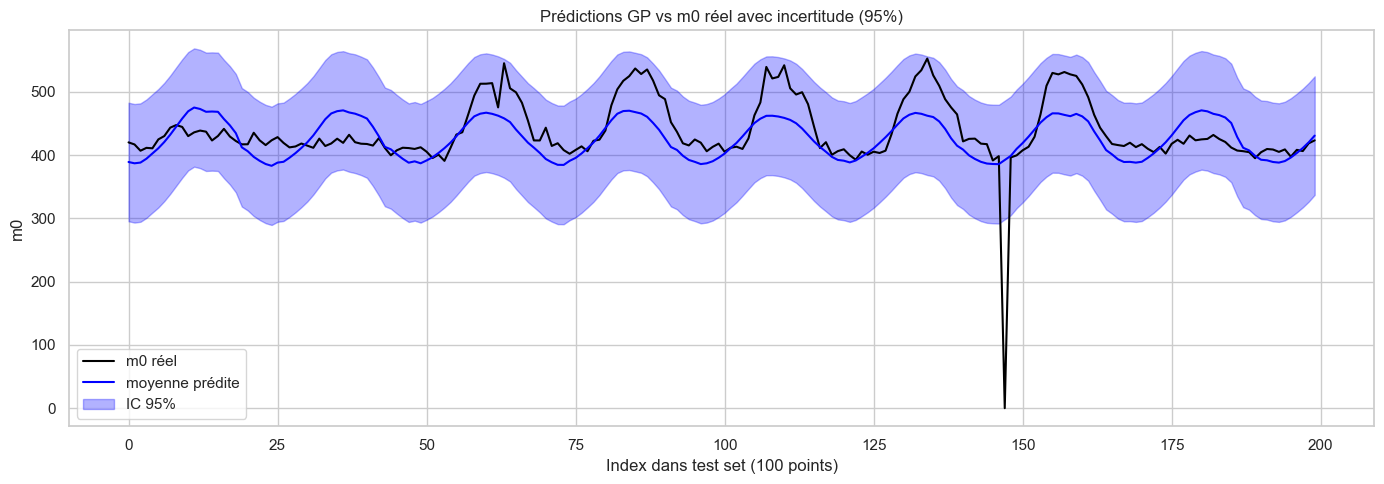

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extraire la moyenne des postérieurs comme dictionnaire pour predict()
mean_params = {
    var: trace.posterior[var].mean().values.item()
    for var in ["length_scale", "variance", "noise", "periodic_scale", "periodic_ls"]
}

# 1. Prédictions bayésiennes sur le jeu de test
with gp_model:
    mu_pred, var_pred = gp.predict(
        X_test.values,       # Données explicatives du test
        point=mean_params,   # Moyenne des postérieurs sous forme de dict
        diag=True,
        pred_noise=True
    )

# 2. Calcul de l'écart-type
std_pred = np.sqrt(var_pred)

# 3. Calcul des intervalles de confiance
lower_bound = mu_pred - 2 * std_pred
upper_bound = mu_pred + 2 * std_pred

# 4. Visualisation 
plt.figure(figsize=(14, 5))
plt.plot(y_test.values, label="m0 réel", color="black")
plt.plot(mu_pred, label="moyenne prédite", color="blue")
plt.fill_between(np.arange(len(mu_pred)), lower_bound, upper_bound, color="blue", alpha=0.3, label="IC 95%")
plt.title("Prédictions GP vs m0 réel avec incertitude (95%)")
plt.xlabel("test set")
plt.ylabel("m0")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
# Définir les bornes de l’intervalle
lower_bound = mu_pred - 2 * std_pred
upper_bound = mu_pred + 2 * std_pred

# Vérifier pour chaque point si y_test est dedans
inside_95 = ((y_test.values >= lower_bound) & (y_test.values <= upper_bound)).sum()
total = len(y_test)
coverage = inside_95 / total * 100

print(f"Inclusion dans l'IC 95% : {coverage:.1f}% ({inside_95} / {total})")


Inclusion dans l'IC 95% : 99.5% (199 / 200)


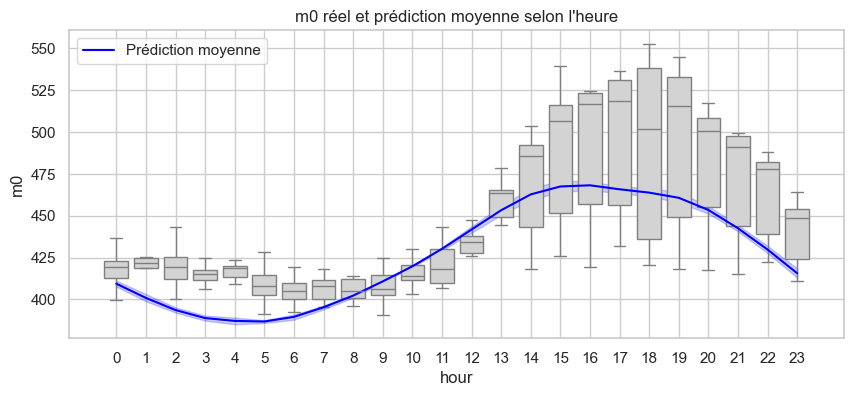

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Concaténer pour une analyse groupée
results_df = test_df.iloc[:150].copy()
results_df["mu_pred"] = mu_pred[:150]
results_df["std_pred"] = std_pred[:150]

# Moyenne réelle et prédite par heure
plt.figure(figsize=(10, 4))
sns.boxplot(x="hour", y="m0", data=results_df, color="lightgray", showfliers=False)
sns.lineplot(x="hour", y="mu_pred", data=results_df, color="blue", label="Prédiction moyenne")
plt.title("m0 réel et prédiction moyenne selon l'heure")
plt.grid(True)
plt.show()
